In [2]:
%matplotlib inline

import os
import sys
import glob
import pprint

import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.display import display

pd.set_option('expand_frame_repr', False)

/Users/mturilli/Virtualenvs/RADICAL-ANALYTICS/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:58: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


In [23]:
# Global configurations
# ---------------------

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75

# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

In [31]:
sessions = pd.read_csv('data/sessions.csv', index_col=0)
pilots = pd.read_csv('data/pilots.csv', index_col=0)
units = pd.read_csv('data/units.csv', index_col=0)

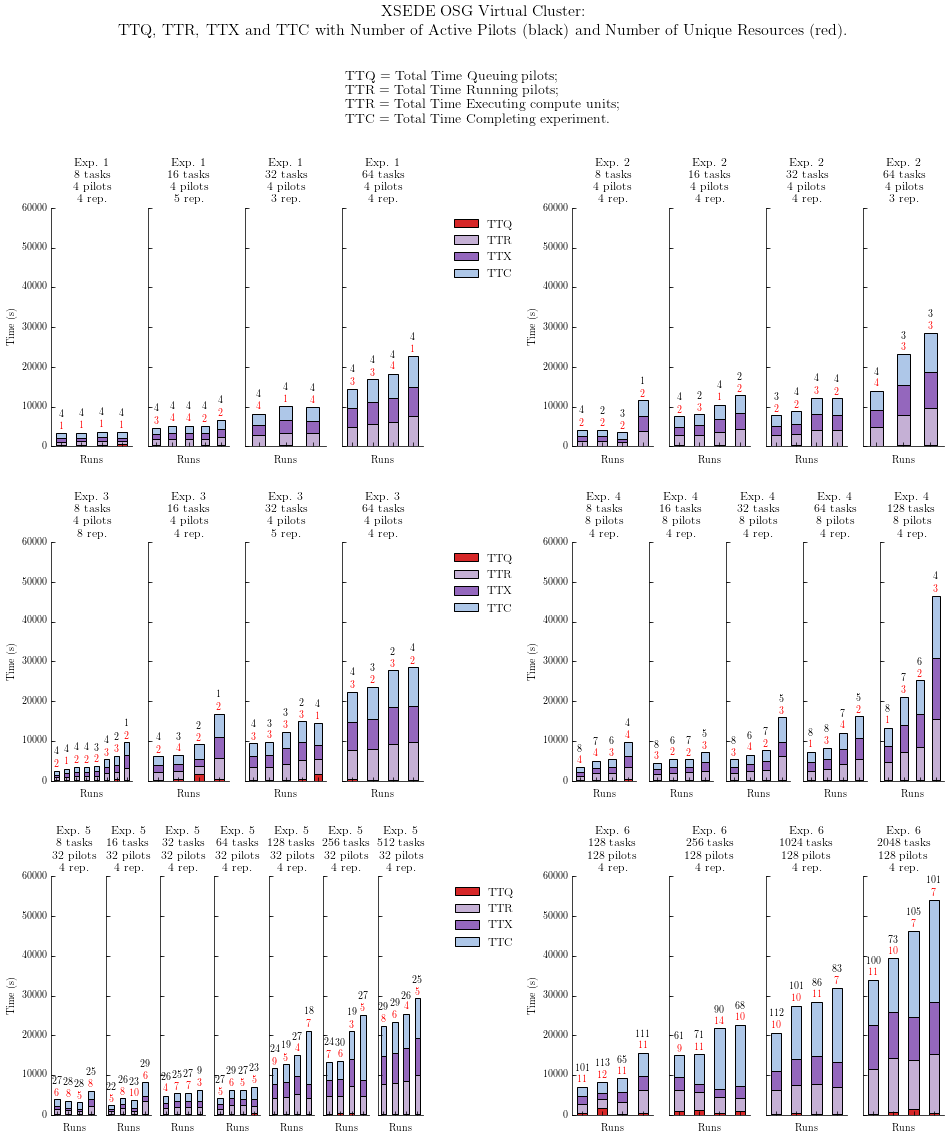

In [5]:
fig = plt.figure(figsize=(16,18))

title = 'XSEDE OSG Virtual Cluster'
subtitle = 'TTQ, TTR, TTX and TTC with Number of Active Pilots (black) and Number of Unique Resources (red)'
fig.suptitle('%s:\n%s.' % (title, subtitle), fontsize=16)

defs = {'ttq': 'TTQ = Total Time Queuing pilots',
        'ttr': 'TTR = Total Time Running pilots',
        'ttx': 'TTR = Total Time Executing compute units',
        'ttc': 'TTC = Total Time Completing experiment'}
defslist = '%s;\n%s;\n%s;\n%s.' % (defs['ttq'], defs['ttr'], defs['ttx'], defs['ttc'])
plt.figtext(.38,.89, defslist, fontsize=14, ha='left')

gs = []
grid  = gridspec.GridSpec(3, 2)
grid.update(wspace=0.4, hspace=0.4, top=0.825)
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[0]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[1]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[2]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=grid[3]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 7, subplot_spec=grid[4]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[5]))

ttq_subplots = []
for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunit'].sort_values().unique():
        if not sessions[(sessions['experiment'] == exp) & (sessions['nunit'] == nun)].empty:
            ttq_subplots.append(sessions[(sessions['experiment'] == exp) & (sessions['nunit'] == nun) ].sort_values('TTC'))

colors = {'exp1': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
          'exp2': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
          'exp3': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
          'exp4': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
          'exp5': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
          'exp6': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]]}


nun_exp = []
nun_exp.append(len(sessions[sessions['experiment'] == 'exp1']['nunit'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp2']['nunit'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp3']['nunit'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp4']['nunit'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp5']['nunit'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp6']['nunit'].sort_values().unique()))

ax = []
i  = 0
while(i < len(ttq_subplots)):
    for gn in range(6):
        for gc in range(nun_exp[gn]):
            session = ttq_subplots.pop(0)
            experiment = session['experiment'].unique()[0]
            ntasks = int(session['nunit'].unique()[0])
            npilots = int(session[session['experiment'] == experiment]['npilot'][0])
            repetitions = session.shape[0]
            color = colors[experiment]
            title = 'Exp. %s\n%s tasks\n%s pilots\n%s rep.' % (experiment[3], ntasks, npilots, repetitions)
            
            if i == 0:
                ax.append(plt.Subplot(fig, gs[gn][0, gc]))
            else:
                ax.append(plt.Subplot(fig, gs[gn][0, gc], sharey=ax[0]))
            session[['P_LRMS_QUEUING', 
                     'P_LRMS_RUNNING',
                     'U_AGENT_EXECUTING',
                     'TTC']].plot(kind='bar', ax=ax[i], color=color, title=title, stacked=True)
            ax[i].spines["top"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].get_xaxis().tick_bottom()
            ax[i].get_yaxis().tick_left()
            ax[i].set_xticklabels([])
            ax[i].set_xlabel('Runs')
            
            # Handle a bug that sets yticklabels to visible 
            # for the last subplot.
            if i == 7 or i == 16 or i == 27:
                plt.setp(ax[i].get_yticklabels(), visible=False)
            else:
                ax[i].set_ylabel('Time (s)')
                
            # Handle legens.
            if i == 3 or i == 11:
                ax[i].legend(labels=['TTQ','TTR','TTX','TTC'], bbox_to_anchor=(2.25, 1))
            elif i == 23:
                ax[i].legend(labels=['TTQ','TTR','TTX','TTC'], bbox_to_anchor=(3.25, 1))
            else:
                ax[i].get_legend().set_visible(False)
                
            # Add labels.
            rects = ax[i].patches
            label_np = [int(l) for l in session['npilot_active']]
            label_nh = [int(l) for l in session['nhost']]
            nh = [r.get_height() for r in rects]
            n = len(nh)/4              # Number of groups of 4 stacked bars
            # partition the list of heights nh into number of bars n partitions;
            # zip partitions into tuples t of n stacked bars;
            # sum eacth tuple into the hight of n stacked bars.
            heights = [sum(t) for t in zip(*[nh[j:j + n] for j in xrange(0, len(nh), n)])]
            
            # Add labels with number of pilots requested per session.
            for rect, label, height in zip(rects[-repetitions:], label_np, heights):
                ax[i].text(rect.get_x() + rect.get_width()/2, 
                           height+3500, label, ha='center', va='bottom')
            
            # Add labels with number of unique resources per session.
            for rect, label, height in zip(rects[-repetitions:], label_nh, heights):
                ax[i].text(rect.get_x() + rect.get_width()/2, 
                           height+500, label, ha='center', va='bottom', color='red')

            fig.add_subplot(ax[i])
            i += 1
            


# Analysis Unit Execution Time ($T_x$)

In [6]:
units['U_AGENT_EXECUTING'].dropna().describe()

count    20024.000000
mean       416.834741
std        244.136827
min          0.379400
25%        252.067650
50%        365.512000
75%        494.151500
max       4135.194400
Name: U_AGENT_EXECUTING, dtype: float64

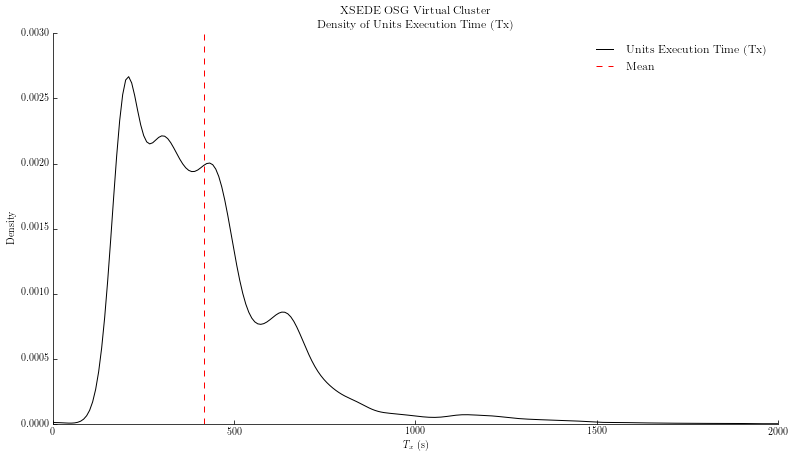

In [7]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx)'

tx_all  = units['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)

utxs = pd.DataFrame({'all': tx_all}) 

utxs.plot.density(ax=ax, color='black', title=title)
#plt.axvline(units['U_AGENT_EXECUTING'].min(),  color='r', linestyle='dashed', linewidth=1)
plt.axvline(units['U_AGENT_EXECUTING'].mean(), color='r', linestyle='dashed', linewidth=1)
#plt.axvline(units['U_AGENT_EXECUTING'].max(),  color='r', linestyle='dashed', linewidth=1)

#ax.set_xlim((0, units['U_AGENT_EXECUTING'].max()+100))
ax.set_xlim(0, 2000)
ax.set_xlabel('$T_x$ (s)')
ax.legend(labels=['Units Execution Time (Tx)', 'Mean'])

utxs.to_csv()
plt.savefig('figures/osg_tx_all_frequency.pdf', dpi=600, bbox_inches='tight')

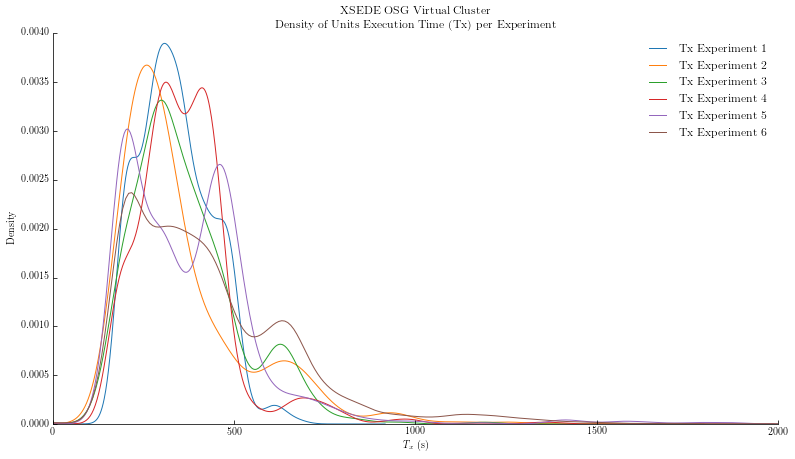

In [8]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx) per Experiment'

tx_exp1 = units[units['experiment'].str.contains('exp1')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp2 = units[units['experiment'].str.contains('exp2')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp3 = units[units['experiment'].str.contains('exp3')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp4 = units[units['experiment'].str.contains('exp4')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp5 = units[units['experiment'].str.contains('exp5')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp6 = units[units['experiment'].str.contains('exp6')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)

utxs = pd.DataFrame({'exp1': tx_exp1, 'exp2': tx_exp2, 'exp3': tx_exp3, 
                     'exp4': tx_exp4, 'exp5': tx_exp5, 'exp6': tx_exp6})

utxs.plot.density(ax=ax, color=[tableau20[0],tableau20[2],tableau20[4],
                                tableau20[6],tableau20[8],tableau20[10]], title=title)

ax.set_xlim((0, 2000))
ax.set_xlabel('$T_x$ (s)')
ax.legend(labels=['Tx Experiment 1', 'Tx Experiment 2', 'Tx Experiment 3', 
                  'Tx Experiment 4', 'Tx Experiment 5', 'Tx Experiment 6'])

plt.savefig('figures/osg_tx_experiments_frequency.pdf', dpi=600, bbox_inches='tight')

In [9]:
from random import shuffle

txd_exp1 = units[units['experiment'].str.contains('exp1')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp2 = units[units['experiment'].str.contains('exp2')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp3 = units[units['experiment'].str.contains('exp3')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp4 = units[units['experiment'].str.contains('exp4')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp5 = units[units['experiment'].str.contains('exp5')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp6 = units[units['experiment'].str.contains('exp6')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_all = units['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()

ntx = units['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).count()
txd_shuffled = units['U_AGENT_EXECUTING'].dropna().sample(n=ntx).reset_index(drop=True)

# Partions with 1/4 elements of the total set of units.
txd_shf1 = txd_shuffled[:3337].describe() 
txd_shf2 = txd_shuffled[3338:6675].describe()
txd_shf3 = txd_shuffled[6675:10012].describe()
txd_shf4 = txd_shuffled[10013:13350].describe()
txd_shf5 = txd_shuffled[13351:16688].describe()
txd_shf6 = txd_shuffled[16689:].describe()

tx_exp_descriptions = pd.DataFrame({'all' : txd_all,
                                    'exp1': txd_exp1, 
                                    'exp2': txd_exp2, 
                                    'exp3': txd_exp3, 
                                    'exp4': txd_exp4,
                                    'exp5': txd_exp5, 
                                    'exp6': txd_exp6,                                    
                                    'shf1': txd_shf1,
                                    'shf2': txd_shf2,
                                    'shf3': txd_shf3,
                                    'shf4': txd_shf4,
                                    'shf5': txd_shf5,
                                    'shf6': txd_shf6,})

tx_exp_descriptions

,all,exp1,exp2,exp3,exp4,exp5,exp6,shf1,shf2,shf3,shf4,shf5,shf6
count,20024.000000,464.000000,416.000000,544.000000,992.00000,4056.000000,13552.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3335.000000
mean,416.834741,338.558248,355.217390,366.800860,363.12296,381.759578,437.844075,411.394313,415.251012,414.500504,426.175951,417.144598,416.500805
std,244.136827,98.210514,174.748009,145.228162,134.14604,207.134340,265.248728,237.664689,243.865750,241.927301,253.365106,242.339204,245.437038
min,0.379400,191.190400,185.204400,136.134200,170.19100,133.432300,0.379400,0.801200,0.999300,0.495100,0.998900,1.315800,0.379400
25%,252.067650,270.311050,237.678925,275.037775,283.03400,207.928125,255.927025,250.250600,247.604400,258.113100,259.810000,249.256600,249.777350
50%,365.512000,328.333200,299.423700,332.309950,345.47195,351.982750,379.371250,363.359700,366.371300,361.421300,379.405500,367.899600,362.364300
75%,494.151500,408.390325,415.966475,442.786625,424.68620,473.470025,554.590400,485.492700,488.489300,491.574400,508.515700,497.272800,489.672550
max,4135.194400,674.719000,1258.610500,1189.620700,1382.52790,2216.327500,4135.194400,2944.944900,3643.638800,3128.847000,4135.194400,3785.789700,2826.828700


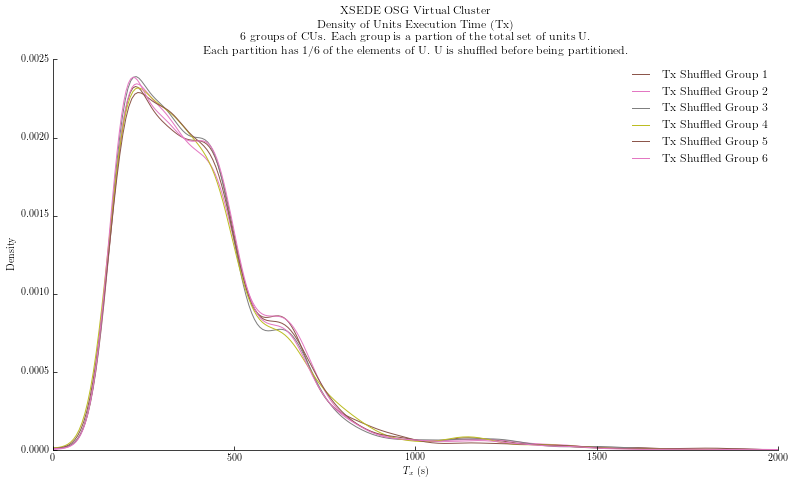

In [10]:
fig, ax = fig_setup()
resource = 'XSEDE OSG Virtual Cluster'
description = 'Density of Units Execution Time (Tx)'
explanation1 = '6 groups of CUs. Each group is a partion of the total set of units U'
explanation2 = 'Each partition has 1/6 of the elements of U. U is shuffled before being partitioned'
title='%s\n%s\n%s.\n%s.' % (resource, description, explanation1, explanation2)

txd_shuffled = units['U_AGENT_EXECUTING'].dropna().sample(n=ntx).reset_index(drop=True)
txd_shf1 = txd_shuffled[:3337].reset_index(drop=True).tolist()
txd_shf2 = txd_shuffled[3338:6675].reset_index(drop=True).tolist()
txd_shf3 = txd_shuffled[6675:10012].reset_index(drop=True).tolist()
txd_shf4 = txd_shuffled[10013:13350].reset_index(drop=True).tolist()
txd_shf5 = txd_shuffled[13351:16688].reset_index(drop=True).tolist()
txd_shf6 = txd_shuffled[16689:].reset_index(drop=True).tolist()


df_shf1 = pd.DataFrame(txd_shf1, columns=['shf1'])
df_shf2 = pd.DataFrame(txd_shf2, columns=['shf2'])
df_shf3 = pd.DataFrame(txd_shf3, columns=['shf3'])
df_shf4 = pd.DataFrame(txd_shf4, columns=['shf4'])
df_shf5 = pd.DataFrame(txd_shf5, columns=['shf6'])
df_shf6 = pd.DataFrame(txd_shf6, columns=['shf6'])

# txd_shfs = pd.concat([df_exp1, df_exp2, df_exp3, df_exp4, 
#                       df_shf1, df_shf2, df_shf3, df_shf4], join='outer', axis=1)
txd_shfs = pd.concat([df_shf1, df_shf2, df_shf3, 
                      df_shf4, df_shf5, df_shf6], join='outer', axis=1)

# txd_shfs.plot.density(ax=ax, title=title, color=[tableau20[0], tableau20[2], tableau20[8], tableau20[4],
#                                                  tableau20[10],tableau20[12],tableau20[14],tableau20[16]])
txd_shfs.plot.density(ax=ax, title=title, color=[tableau20[10],tableau20[12],tableau20[14],tableau20[16]])

#ax.set_xlim((0, units['U_AGENT_EXECUTING'].max()+100))
ax.set_xlim(0, 2000)
ax.set_xlabel('$T_x$ (s)')

ax.legend(labels=['Tx Shuffled Group 1','Tx Shuffled Group 2',
                  'Tx Shuffled Group 3','Tx Shuffled Group 4',
                  'Tx Shuffled Group 5','Tx Shuffled Group 6'])

plt.savefig('figures/osg_tx_shuffled_frequency.pdf', dpi=600, bbox_inches='tight')

## $T_x$ as Function of Resource Heterogeneity

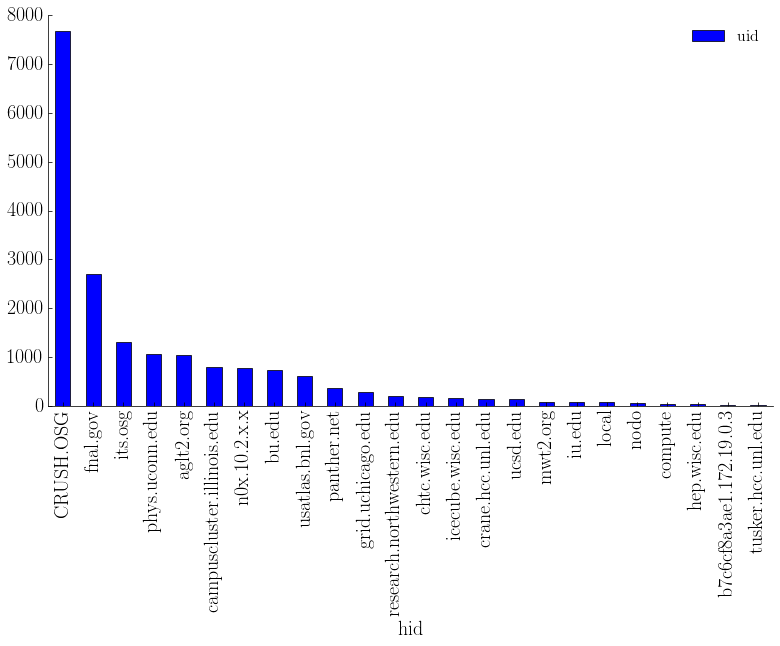

In [36]:
us = units
fig, ax = fig_setup()
us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False).plot.bar(ax=ax)

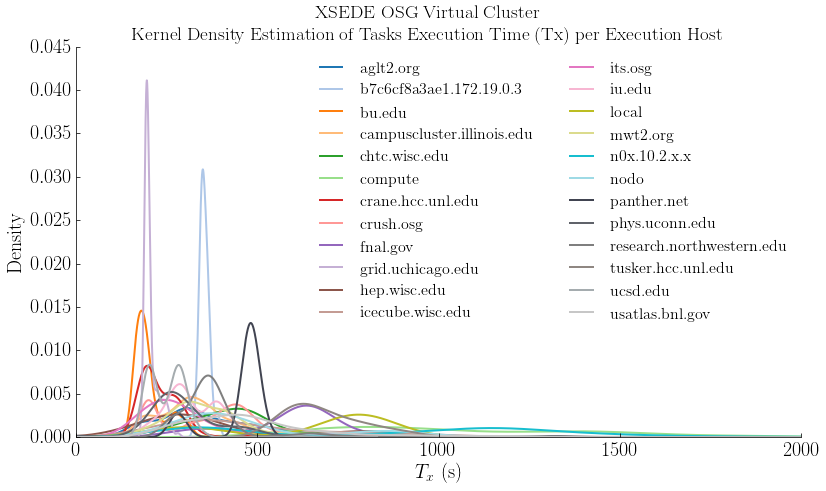

In [24]:
fig, ax = fig_setup()

# mpl.rcParams['text.usetex'] = True 
# mpl.rcParams['font.family'] = 'sans-serif'
# mpl.rcParams['font.serif']  = ['Helvetica']

mpl.rcParams['legend.frameon']  = False
mpl.rcParams['patch.linewidth'] = 0.75
mpl.rcParams['axes.linewidth']  = 0.75

SIZE = 20
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=16)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(111)  

title='XSEDE OSG Virtual Cluster\nKernel Density Estimation of Tasks Execution Time (Tx) per Execution Host'
fig.suptitle(title, fontsize=19)

curves = {}
hosts = units['hid'].dropna().unique()

for host in hosts:
    curves[host] = units[units['hid'] == host]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)

curves = dict((k.lower(), v) for k,v in curves.iteritems())
    
utxh = pd.DataFrame(curves) 

utxh.plot.density(ax=ax, sort_columns=True, color=tableau20, linewidth=2)#, figsize=(15, 13), title=title) # subplots=True, layout=(4,4), sharey=True, sharex=True,
# plt.axvline(units['UNIT_AGENT_EXECUTING'].min(), color='r', linestyle='dashed', linewidth=1)
# plt.axvline(units['UNIT_AGENT_EXECUTING'].mean(), color='r', linestyle='dashed', linewidth=1)
# plt.axvline(units['UNIT_AGENT_EXECUTING'].max(), color='r', linestyle='dashed', linewidth=1)

ax.legend(ncol=2)
ax.set_xlim((0, 2000))
ax.set_xlabel('$T_x$ (s)')

plt.savefig('figures/osg_tx_hosts_frequency.pdf', dpi=600, bbox_inches='tight')

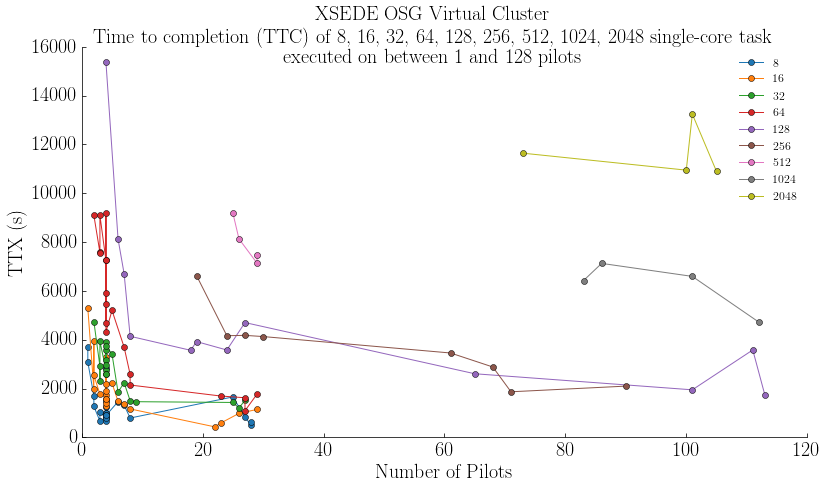

In [15]:
fig, ax = fig_setup()
fig.suptitle('XSEDE OSG Virtual Cluster\nTime to completion (TTC) of 8, 16, 32, 64, 128, 256, 512, 1024, 2048 single-core task\nexecuted on between 1 and 128 pilots')

s = sessions.rename(columns={'npilot_active':'npilotactive'})

colors=[tableau20[0], tableau20[2],  tableau20[4],  tableau20[6], 
        tableau20[8], tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18]]

for u in [8,16,32,64,128,256,512,1024,2048]:
    units = s[s['nunit']==u][['U_AGENT_EXECUTING', 'npilotactive']].sort_values('npilotactive').copy()
    ax.plot(units.npilotactive, units.U_AGENT_EXECUTING, marker='o', label=u, color=colors.pop(0))

#ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax.legend(numpoints=1)
ax.set_xlabel('Number of Pilots')
ax.set_ylabel('TTX (s)')

plt.savefig('figures/osg_ttx_pilots.pdf', dpi=600, bbox_inches='tight')

plt.savefig('figures/osg_ttx_active-pilots.pdf', dpi=600, bbox_inches='tight')